# Cycling Assessment

_By: Manuel Urbano Rodriguez_

The purpose of this assessment is to understand how you approach analysis and the application of data science to a business problem.

- You should aim to spend around half a day to a day on this exercise.
- You **must** use Python to complete this assessment.
- You may also use SQL for performing queries and data modelling.

#### Problem Statement
One of our clients is considering expanding their business into short term rental-cycles. Before investing, they would like to understand how people in London use cycling services in order to develop their strategy. We have been asked to look at existing biking usage patterns to help them with this.

From an initial meeting, they suggested that they were interested in what kinds of usage they might expect to see, what profile of customers they might have, as well as operational concerns such as reliability and supply chain management.

#### The Ask
After the initial client meeting, we’d like to get back to them with an initial response as well as some suggestions for how they can use data to make their expansion a success. Using the TFL cycling dataset (https://cycling.data.tfl.gov.uk/) `usage-stats` data from 2019 to 2021:
1. Perform exploratory analysis on the dataset
2. Identify possible data science use cases with the data
3. Select a use case and prototype a model to demonstrate the application of data
science to solving their problem
4. Make two recommendations for the client

#### Submission
You must submit the following via email, in a zipped archive:
1. A 3-4 slide presentation outlining your findings and recommendations
2. The code you used to perform the analysis


In [ ]:
#!pip install selenium
#!pip install bs4
#!pip install webdriver-manager
#!pip install wwo-hist
#!pip install urllib3

## 0 Importing Packages

In [65]:
import os
import pandas as pd
import numpy as np
from datetime import timedelta
import seaborn as sns
import matplotlib.pyplot as plt

import requests
from xml.etree import ElementTree as ET

from wwo_hist import retrieve_hist_data

from bs4 import BeautifulSoup

# selenium will be used to scrap dynamic content of the webpage source of our data
from selenium import webdriver
from webdriver_manager.firefox import GeckoDriverManager
from selenium.webdriver.firefox.options import Options
from selenium.webdriver.firefox.service import Service 
from selenium.webdriver.common.desired_capabilities import DesiredCapabilities

from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

from scipy.stats import pearsonr

from sklearn.linear_model import LinearRegression
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score, mean_squared_log_error
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold, cross_val_score, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import OneHotEncoder


pd.options.mode.chained_assignment = None  # default='warn'

os.environ['GH_TOKEN'] = "" # Insert Github Token

## 1 Data Acqustision - Web Scraping

In this section, data from the TfL website is scraped using the provided time of interest, from 2019 to 2021. Data is gathered and concatenated into a single Pandas Dataframe. In the following section, data will be cleaned and visualised.

In [2]:
url= "https://cycling.data.tfl.gov.uk"

cap = DesiredCapabilities().FIREFOX
cap["marionette"] = False

options = Options()
options.add_argument("--headless")

browser = webdriver.Firefox(service=Service(GeckoDriverManager().install()), options=options)
browser.get(url)

# wait until at least a single element of the table exists
wait = WebDriverWait(browser, 20)
html = wait.until(EC.presence_of_element_located((By.XPATH, '/html/body/div[2]/table/tbody/tr[1]/td[1]')))

html_element= browser.page_source

[WDM] - ====== WebDriver manager ======
[WDM] - Current firefox version is 101.0
[WDM] - Get LATEST geckodriver version for 101.0 firefox
[WDM] - GH_TOKEN will be used to perform requests
[WDM] - Driver [C:\Users\manue\.wdm\drivers\geckodriver\win64\v0.31.0\geckodriver.exe] found in cache


In [3]:
bsoup= BeautifulSoup(html_element, "html.parser")

In [30]:
# find the relevant files with their links
table= bsoup.find('table')
tbody= table.find('tbody')
folder_name= "usage-stats/"
capture_files= False
years = [2019, 2020, 2021]
filetype= 'csv'
extracted_files= {}

for row in tbody.find_all('tr'):
    columns= row.find_all('td')

    if capture_files == False:
        col_values= [col.text.strip() for col in columns]

        if col_values[0] == folder_name:
            capture_files= True
            continue

    else:
        col= columns[0]
        filename= col.text.strip()
        
        if not (filename.endswith(f'{years[0]}.{filetype}') or filename.endswith(f'{years[1]}.{filetype}') or filename.endswith(f'{years[2]}.{filetype}')):
            continue
        
        # extract the date
        filename_without_extension= filename.replace(f'.{filetype}', '') 
        filename_last_date= filename_without_extension.split('-')[-1]
        extracted_files[filename_last_date]= col.a['href']

dict_csv = dict(list(extracted_files.items())[1:])

print('A total of {} CSV files were found'.format(len(dict_csv)))
dict(list(extracted_files.items())[0:10])

A total of 156 CSV files were found


{'01Jan2019': 'https://cycling.data.tfl.gov.uk/usage-stats/142JourneyDataExtract26Dec2018-01Jan2019.csv',
 '08Jan2019': 'https://cycling.data.tfl.gov.uk/usage-stats/143JourneyDataExtract02Jan2019-08Jan2019.csv',
 '15Jan2019': 'https://cycling.data.tfl.gov.uk/usage-stats/144JourneyDataExtract09Jan2019-15Jan2019.csv',
 '22Jan2019': 'https://cycling.data.tfl.gov.uk/usage-stats/145JourneyDataExtract16Jan2019-22Jan2019.csv',
 '29Jan2019': 'https://cycling.data.tfl.gov.uk/usage-stats/146JourneyDataExtract23Jan2019-29Jan2019.csv',
 '05Feb2019': 'https://cycling.data.tfl.gov.uk/usage-stats/147JourneyDataExtract30Jan2019-05Feb2019.csv',
 '12Feb2019': 'https://cycling.data.tfl.gov.uk/usage-stats/148JourneyDataExtract06Feb2019-12Feb2019.csv',
 '19Feb2019': 'https://cycling.data.tfl.gov.uk/usage-stats/149JourneyDataExtract13Feb2019-19Feb2019.csv',
 '26Feb2019': 'https://cycling.data.tfl.gov.uk/usage-stats/150JourneyDataExtract20Feb2019-26Feb2019.csv',
 '05Mar2019': 'https://cycling.data.tfl.gov.uk

In [5]:
csv_urls = pd.DataFrame({'dates':dict_csv.keys(),'url':dict_csv.values()})

dfs = (pd.read_csv(url) for url in csv_urls['url'])

all_data = pd.concat(dfs, ignore_index=True)
#all_data.to_hdf('all_data_int64.h5', key='all_data', mode='w')
all_data.head()

,Rental Id,Duration,Bike Id,End Date,EndStation Id,EndStation Name,Start Date,StartStation Id,StartStation Name
0,83284852,660,8282,02/01/2019 17:47,94,"Bricklayers Arms, Borough",02/01/2019 17:36,197,"Stamford Street, South Bank"
1,83360769,180,4657,06/01/2019 18:14,94,"Bricklayers Arms, Borough",06/01/2019 18:11,269,"Empire Square, The Borough"
2,83280311,960,6306,02/01/2019 14:49,374,"Waterloo Station 1, Waterloo",02/01/2019 14:33,5,"Sedding Street, Sloane Square"
3,83323626,120,6217,04/01/2019 12:54,269,"Empire Square, The Borough",04/01/2019 12:52,94,"Bricklayers Arms, Borough"
4,83343322,120,848,05/01/2019 16:03,269,"Empire Square, The Borough",05/01/2019 16:01,94,"Bricklayers Arms, Borough"


## 2 Data Wrangling

In [6]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31348502 entries, 0 to 31348501
Data columns (total 9 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   Rental Id          int64 
 1   Duration           int64 
 2   Bike Id            int64 
 3   End Date           object
 4   EndStation Id      int64 
 5   EndStation Name    object
 6   Start Date         object
 7   StartStation Id    int64 
 8   StartStation Name  object
dtypes: int64(5), object(4)
memory usage: 2.3+ GB


### 2.1 Data Cleaning

#### 2.1.1 Data Types

By modifying the data type of columns in int64 to int32, it is possible to save some useful space in memory for other operations.

In [7]:
max_int32 = 2147483647
old_mem = all_data.memory_usage().sum()

for col in all_data.columns:
    if (all_data[col].dtypes == 'int64') and (all_data[col].max() < max_int32):
        all_data[col] = all_data[col].astype('int32')
        
new_mem = all_data.memory_usage().sum()

print('The size was reduced by a total of {:.2f}MB.'.format((old_mem-new_mem)/1000000))

The size was reduced by a total of 626.97MB.


#### 2.1.2 Drop Empty Values

Values that do not contain a Start Station, End Station, Start Date or End Date, can be dropped.

In [8]:
pre_shape = all_data.shape[0]
all_data.dropna(axis=0, subset=["StartStation Id", "EndStation Id", "Start Date", "End Date"], inplace=True)
post_shape = all_data.shape[0]

print('A total of {} were dropped from the Dataset for values missing regarding the start station, end station or dates of trip.'.format(pre_shape-post_shape))

A total of 0 were dropped from the Dataset for values missing regarding the start station, end station or dates of trip.


#### 2.1.3 Drop Duplicates

Duplicates need to be dropped so that our statistical findings are not biased later in the analysis.

In [9]:
pre_shape = all_data.shape[0]
all_data.drop_duplicates(subset=['Rental Id'], inplace=True)
post_shape = all_data.shape[0]

print('A total of {} duplicates were dropped from the Dataset.'.format(pre_shape-post_shape))

A total of 0 duplicates were dropped from the Dataset.


#### 2.1.4 Drop Trips to and from the Same Station within 3 minutes

Trips that start and finish at the same station within a period of 3 minutes will not offer any relevant information to our analysis.

In [10]:
pre_shape = all_data.shape[0]
cropped = all_data[((all_data["StartStation Id"] == all_data["EndStation Id"]) & (all_data["Duration"] > 3*60)) | (all_data["StartStation Id"] != all_data["EndStation Id"])]
post_shape = cropped.shape[0]

print('A total of {} duplicates were dropped from the Dataset.'.format(pre_shape-post_shape))

A total of 177821 duplicates were dropped from the Dataset.


#### 2.1.5 Drop Trips Longer than 6 hours

Trips that are longer than 6 hours can be considered as outliers looking at the distribution below, therefore, it is better to drop them not to bias the analysis.

A total of 58944 duplicates were dropped from the Dataset.


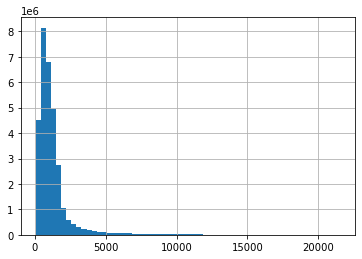

In [11]:
pre_shape = cropped.shape[0]
cropped_dur = cropped[cropped["Duration"] < 6*60*60]
post_shape = cropped_dur.shape[0]

print('A total of {} duplicates were dropped from the Dataset.'.format(pre_shape-post_shape))

hist = cropped_dur['Duration'].hist(bins=60)

### 2.2 Selecting Most Relevant columns

Redundant or non-relevant columns can be dropped to prevent an inneficient use of memory. This will help speed up the computations.

In [13]:
cropped_cols = cropped_dur[['Bike Id','Duration','StartStation Id','Start Date','EndStation Id','End Date']]

# Convert columns to datetime
cropped_cols['Start Date'] = pd.to_datetime(cropped_cols['Start Date'], format='%d/%m/%Y %H:%M', dayfirst=True)
cropped_cols['End Date'] = pd.to_datetime(cropped_cols['End Date'], format='%d/%m/%Y %H:%M', dayfirst=True)

cropped_cols.tail()

,Bike Id,Duration,StartStation Id,Start Date,EndStation Id,End Date
31348497,19041,1080,603,2021-12-28 12:56:00,148,2021-12-28 13:14:00
31348498,203,1440,603,2021-12-26 15:51:00,9,2021-12-26 16:15:00
31348499,19576,1260,603,2021-12-25 17:42:00,602,2021-12-25 18:03:00
31348500,9180,900,603,2021-12-25 17:08:00,794,2021-12-25 17:23:00
31348501,17062,600,603,2021-12-26 17:14:00,149,2021-12-26 17:24:00


A this point, data can be exported to avoid performing the analysis above every time that the notebook is opened.

In [14]:
#cropped_cols.to_hdf('cleanedDf.h5', key='all_data', mode='w')
#cropped_cols.head()
#cropped_cols = pd.read_hdf('cleanedDf.h5')
#cropped_cols.head()

,Bike Id,Duration,StartStation Id,Start Date,EndStation Id,End Date
0,8282,660,197,2019-01-02 17:36:00,94,2019-01-02 17:47:00
1,4657,180,269,2019-01-06 18:11:00,94,2019-01-06 18:14:00
2,6306,960,5,2019-01-02 14:33:00,374,2019-01-02 14:49:00
3,6217,120,94,2019-01-04 12:52:00,269,2019-01-04 12:54:00
4,848,120,94,2019-01-05 16:01:00,269,2019-01-05 16:03:00


### 2.3 Grouping Data

In [15]:
cropped_cols = cropped_cols.set_index('Start Date')

# Setting a value to keep a record of trips when grouping
cropped_cols['trip_count'] = 1

#### 2.3.1 Grouping per Days

In [16]:
cropped_freq = cropped_cols.resample('1440min').sum()
cropped_freq

,Bike Id,Duration,StartStation Id,EndStation Id,trip_count
Start Date,,,,,
2019-01-02,172561775,19195500,7066141,6972411,19444
2019-01-03,187922518,19451100,7575874,7481233,21244
2019-01-04,183020185,18684240,7457773,7321497,20584
2019-01-05,121833331,14105760,5600855,5561915,13683
2019-01-06,126096961,15857100,5801418,5746607,14045
...,...,...,...,...,...
2021-12-24,154558793,9431760,3966357,3921968,9990
2021-12-25,212067476,26269620,5705760,5756453,14566
2021-12-26,119092559,11347500,3184479,3161088,8051


#### 2.3.2 Grouping Data in Batches of 30 minutes

In [17]:
cropped_freq_30 = cropped_cols.resample('30min').sum()
cropped_freq_30['just_date'] = cropped_freq_30.index.astype('str').str[:10]
cropped_freq_30 = cropped_freq_30.reset_index()
cropped_freq_30

,Start Date,Bike Id,Duration,StartStation Id,EndStation Id,trip_count,just_date
0,2019-01-02 00:00:00,404701,72120,18265,18593,48,2019-01-02
1,2019-01-02 00:30:00,400864,35940,16131,17294,45,2019-01-02
2,2019-01-02 01:00:00,325300,58080,17261,12266,42,2019-01-02
3,2019-01-02 01:30:00,161696,26820,10060,8612,22,2019-01-02
4,2019-01-02 02:00:00,91470,20760,3764,3946,10,2019-01-02
...,...,...,...,...,...,...,...
52411,2021-12-28 21:30:00,4025970,372900,107419,113951,281,2021-12-28
52412,2021-12-28 22:00:00,4618278,441000,111109,129632,316,2021-12-28
52413,2021-12-28 22:30:00,4048145,307140,111828,124056,280,2021-12-28
52414,2021-12-28 23:00:00,2793828,173520,70495,76029,187,2021-12-28


In [18]:
cropped_freq_30['just_date'] = pd.to_datetime(cropped_freq_30['just_date'], format='%Y-%m-%d', dayfirst=True)

Creating a new Dataframe with a timestamp, weekday name, whether it is a workday or not considering bankholidays, whether the record is part of the peak hours and whether the record was affected by one of the Covid-19 Lockdowns.

In [19]:
# Data obtained from https://www.gov.uk/bank-holidays 
bank_hols_list = ['01/01/2019', # New Year's Day substitute
                  '19/04/2019', # Good Friday
                  '22/04/2019', # Easter Monday
                  '06/05/2019', # Early May
                  '27/05/2019', # Spring
                  '26/08/2019', # Summer
                  '25/12/2019', # Christmas Day
                  '26/12/2019', # Boxing Day
                  '01/01/2020', # New Year's Day
                  '10/04/2020',
                  '13/04/2020',
                  '08/05/2020',
                  '25/05/2020',
                  '31/08/2020',
                  '25/12/2020',
                  '26/12/2020',
                  '01/01/2021',
                  '02/04/2021',
                  '05/05/2021',
                  '03/05/2021',
                  '31/05/2021',
                  '30/08/2021', 
                  '27/12/2021',
                  '28/12/2021']

# Data obtained from https://www.instituteforgovernment.org.uk/charts/uk-government-coronavirus-lockdowns
covid_relevant_dates = ['26/03/2020', # First Lockdown
                        '14/08/2020', # Lockdown restrictions are eased
                        '05/11/2020', # Second lockdown
                        '21/12/2020', # Tier 4 restrictions are enforeced
                        '06/01/2021', # Third National Lockdown
                        '29/03/2021'] # End of 'Stay at home'

lockdowns = ['26/03/2020', # First Lockdown
             '05/11/2020', # Second lockdown
             '21/12/2020'] # Third National Lockdown
                        

eased_restrictions = ['14/08/2020', # Lockdown restrictions are eased
                      '02/12/2020', # Second lockdown end
                      '29/03/2021'] # End of 'Stay at home'

bank_hols = pd.DatetimeIndex(bank_hols_list, dayfirst=True)
covid_dates = pd.DatetimeIndex(covid_relevant_dates, dayfirst=True)

# peak travel hours 
wd_peak = [6.5, 7.0, 7.5, 8.0, 8.5, 9.0, 9.5,  # morning peak
           16.0, 16.5, 17.0, 17.5, 18.0, 18.5, 19.0] #, 19.5, 20.0, 20.5] # evening peak

date_time_att = pd.DataFrame()
date_time_att['time_stamp'] = cropped_freq_30['Start Date'] # only process observation for which we have weather
date_time_att['weekday_name'] = date_time_att.time_stamp.dt.day_name()
date_time_att['workday'] = np.where((date_time_att.time_stamp.dt.weekday == 5) | (date_time_att.time_stamp.dt.weekday == 6), 0, 1)
date_time_att['workday'] = np.where(cropped_freq_30.just_date.isin(bank_hols), 0, date_time_att.workday) #-1

date_time_att['covid_days'] = 0
for start, end in zip(lockdowns, eased_restrictions):
    date_time_att['covid_days'].loc[(date_time_att['time_stamp'] >= start) & (date_time_att['time_stamp'] <= end)] = 1

date_time_att['month'] = date_time_att.time_stamp.dt.month
date_time_att['hour'] = date_time_att.time_stamp.dt.hour + date_time_att.time_stamp.dt.minute / 60
date_time_att['peak_travel'] = np.where((date_time_att.workday==1) & (date_time_att.time_stamp.dt.hour.isin(wd_peak)),1,0)
date_time_att['just_date'] = date_time_att.time_stamp.astype('str').str[:10]
date_time_att['trip_count'] = cropped_freq_30['trip_count']

date_time_att.head()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arraylike.py:60: UserWarning: Parsing '26/03/2020' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  return self._cmp_method(other, operator.ge)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arraylike.py:52: UserWarning: Parsing '14/08/2020' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  return self._cmp_method(other, operator.le)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arraylike.py:60: UserWarning: Parsing '21/12/2020' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  return self._cmp_method(other, operator.ge)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arraylike.py:52: UserWarning: Parsing '29/03/2021' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  return self._cmp_method(other, operator.

,time_stamp,weekday_name,workday,covid_days,month,hour,peak_travel,just_date,trip_count
0,2019-01-02 00:00:00,Wednesday,1,0,1,0.0,0,2019-01-02,48
1,2019-01-02 00:30:00,Wednesday,1,0,1,0.5,0,2019-01-02,45
2,2019-01-02 01:00:00,Wednesday,1,0,1,1.0,0,2019-01-02,42
3,2019-01-02 01:30:00,Wednesday,1,0,1,1.5,0,2019-01-02,22
4,2019-01-02 02:00:00,Wednesday,1,0,1,2.0,0,2019-01-02,10


### 2.4 Weather Data

Obtaining historical weather data using the Historical Weather API: https://www.worldweatheronline.com/developer/api/historical-weather-api.aspx

In [ ]:
frequency = 24
start_date = '01-JAN-2019'
end_date = '31-DEC-2021'
api_key = '' # Insert API key
location_list = ['london']

hist_weather_data = retrieve_hist_data(api_key,
                                    location_list,
                                    start_date,
                                    end_date,
                                    frequency,
                                    location_label = False,
                                    export_csv = True,
                                    store_df = True)


In [22]:
londonWeatherDf = pd.read_csv('data/london.csv')

avg_temp = 0.75*londonWeatherDf['maxtempC']+0.25*londonWeatherDf['mintempC']
londonWeatherDf['avg_temp'] = avg_temp

londonWeather_cut = londonWeatherDf[['date_time','avg_temp','precipMM','WindGustKmph','cloudcover']].set_index('date_time')
londonWeather_cut.loc[londonWeather_cut['precipMM']==0,'precipType'] = 'No Rain'
londonWeather_cut.loc[(londonWeather_cut['precipMM'] > 0) & (londonWeather_cut['precipMM'] < 8),'precipType'] = 'Moderate Rain'
londonWeather_cut.loc[londonWeather_cut['precipMM'] >= 8,'precipType'] = 'Heavy Rain'

londonWeather_cut.loc[londonWeather_cut['WindGustKmph']<12,'windType'] = 'Light Wind'
londonWeather_cut.loc[(londonWeather_cut['WindGustKmph'] >= 12) & (londonWeather_cut['precipMM'] < 26),'windType'] = 'Moderate Wind'
londonWeather_cut.loc[londonWeather_cut['WindGustKmph'] >= 26,'windType'] = 'Heavy Rain'

londonWeather_cut

,avg_temp,precipMM,WindGustKmph,cloudcover,precipType,windType
date_time,,,,,,
2019-01-01,9.25,0.3,17,54,Moderate Rain,Moderate Wind
2019-01-02,5.50,0.0,13,23,No Rain,Moderate Wind
2019-01-03,4.25,0.0,7,33,No Rain,Light Wind
2019-01-04,2.75,0.0,8,33,No Rain,Light Wind
2019-01-05,5.25,0.1,12,65,Moderate Rain,Moderate Wind
...,...,...,...,...,...,...
2021-12-27,9.25,0.3,9,92,Moderate Rain,Light Wind
2021-12-28,9.25,0.9,26,74,Moderate Rain,Heavy Rain
2021-12-29,15.00,8.6,27,85,Heavy Rain,Heavy Rain


#### Merging with Date-Time Data

In [23]:
date_time_weather = date_time_att.merge(londonWeather_cut, left_on='just_date', right_on='date_time',copy=False)
date_time_weather

,time_stamp,weekday_name,workday,covid_days,month,hour,peak_travel,just_date,trip_count,avg_temp,precipMM,WindGustKmph,cloudcover,precipType,windType
0,2019-01-02 00:00:00,Wednesday,1,0,1,0.0,0,2019-01-02,48,5.50,0.0,13,23,No Rain,Moderate Wind
1,2019-01-02 00:30:00,Wednesday,1,0,1,0.5,0,2019-01-02,45,5.50,0.0,13,23,No Rain,Moderate Wind
2,2019-01-02 01:00:00,Wednesday,1,0,1,1.0,0,2019-01-02,42,5.50,0.0,13,23,No Rain,Moderate Wind
3,2019-01-02 01:30:00,Wednesday,1,0,1,1.5,0,2019-01-02,22,5.50,0.0,13,23,No Rain,Moderate Wind
4,2019-01-02 02:00:00,Wednesday,1,0,1,2.0,0,2019-01-02,10,5.50,0.0,13,23,No Rain,Moderate Wind
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52411,2021-12-28 21:30:00,Tuesday,0,0,12,21.5,0,2021-12-28,281,9.25,0.9,26,74,Moderate Rain,Heavy Rain
52412,2021-12-28 22:00:00,Tuesday,0,0,12,22.0,0,2021-12-28,316,9.25,0.9,26,74,Moderate Rain,Heavy Rain
52413,2021-12-28 22:30:00,Tuesday,0,0,12,22.5,0,2021-12-28,280,9.25,0.9,26,74,Moderate Rain,Heavy Rain
52414,2021-12-28 23:00:00,Tuesday,0,0,12,23.0,0,2021-12-28,187,9.25,0.9,26,74,Moderate Rain,Heavy Rain


### 2.5 Station Names and Locations

Obtaining Station Names and coordinates from the Live Cycle Hire Updates XML file from the TfL website.

In [24]:
url = 'https://tfl.gov.uk/tfl/syndication/feeds/cycle-hire/livecyclehireupdates.xml'

web_response = requests.get(url)
root = ET.fromstring(web_response.content)

ids = [int(root[i][0].text) for i in range(0, len(root))]
names = [root[i][1].text for i in range(0, len(root))]
latitudes = [float(root[i][3].text) for i in range(0, len(root))]
longitudes = [float(root[i][4].text) for i in range(0, len(root))]

stationsDf = pd.DataFrame({'id':ids,
                           'name':names,
                           'latitude':latitudes,
                           'longitude':longitudes})

stationsDf.head(10)

,id,name,latitude,longitude
0,1,"River Street , Clerkenwell",51.529163,-0.109971
1,2,"Phillimore Gardens, Kensington",51.499607,-0.197574
2,3,"Christopher Street, Liverpool Street",51.521284,-0.084606
3,4,"St. Chad's Street, King's Cross",51.530059,-0.120974
4,5,"Sedding Street, Sloane Square",51.493130,-0.156876
5,6,"Broadcasting House, Marylebone",51.518118,-0.144229
6,7,"Charlbert Street, St. John's Wood",51.534300,-0.168074
7,8,"Maida Vale, Maida Vale",51.529857,-0.183486
8,9,"New Globe Walk, Bankside",51.507385,-0.096441
9,10,"Park Street, Bankside",51.505974,-0.092754


In [25]:
stationsDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 788 entries, 0 to 787
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         788 non-null    int64  
 1   name       788 non-null    object 
 2   latitude   788 non-null    float64
 3   longitude  788 non-null    float64
dtypes: float64(2), int64(1), object(1)
memory usage: 24.8+ KB


In [26]:
xlims = (stationsDf['longitude'].min(), stationsDf['longitude'].max())
ylims = (stationsDf['latitude'].min(), stationsDf['latitude'].max())

## 3 Visual Data Exploration

### 3.1 Most Popular Routes

In [31]:
def get_most_pop(df):
    '''
    Obtain a Dataframe with the 100 most common routes.
    
    Parameters
    -------
    df : Pandas DataFrame
        DataFrame of interest with cleaned data.
    Returns
    -------
    df_most_comm : Pandas DataFrame
        Dataframe with 100 most common routes.
    '''
    df['station_comb'] = df['StartStation Id'].astype(str) + ' ' + df['EndStation Id'].astype(str)
    df_most_comm = df['station_comb'].value_counts().reset_index().head(100)
    df_most_comm[['expand_comb_start','expand_comb_end']] = df_most_comm['index'].str.split(' ',expand=True)
    return df_most_comm

In [32]:
# Obtain most common routes in all data
most_common_routes_all = get_most_pop(cropped_cols)
most_common_routes_all

,index,station_comb,expand_comb_start,expand_comb_end
0,785 785,62949,785,785
1,191 191,44338,191,191
2,307 307,25887,307,307
3,111 111,25222,111,111
4,303 303,25139,303,303
...,...,...,...,...
95,768 768,4366,768,768
96,789 786,4362,789,786
97,772 624,4339,772,624
98,46 488,4299,46,488


In [33]:
# Obtain most common routes of trips that started and ended in different stations
cropped_cols_diff = cropped_cols[cropped_cols['StartStation Id']!=cropped_cols['EndStation Id']]
most_common_routes_diff = get_most_pop(cropped_cols_diff)
most_common_routes_diff

,index,station_comb,expand_comb_start,expand_comb_end
0,785 789,11668,785,789
1,789 785,11322,789,785
2,191 248,10211,191,248
3,191 303,10186,191,303
4,191 300,9845,191,300
...,...,...,...,...
95,787 789,3213,787,789
96,436 14,3211,436,14
97,492 499,3205,492,499
98,492 505,3199,492,505


#### Merging Datasets

In [34]:
def get_st_names(df, stationsDf):
    '''
    Obtain the station names.
    
    Parameters
    -------
    df : Pandas DataFrame
        Dataframe of interest.
    stationsDf : Pandas DataFrame
        Dataframe with stations data.
    Returns
    -------
    df_aux_end : Pandas DataFrame
        Dataframe with merged data.
    '''
    df['expand_comb_start'] = df['expand_comb_start'].astype('int64')
    df['expand_comb_end'] = df['expand_comb_end'].astype('int64')

    stationsDf = stationsDf[['id','name']]

    df_aux = df.merge(stationsDf, left_on='expand_comb_start', right_on='id',copy=False)
    df_aux = df_aux.drop(columns=['id'],axis=1)
    df_aux.rename({'name': 'name_start_st'}, axis=1, inplace=True)
    
    df_aux_end = df_aux.merge(stationsDf, left_on='expand_comb_end', right_on='id',copy=False)
    df_aux_end = df_aux_end.drop(columns=['id'],axis=1)
    df_aux_end.rename({'name': 'name_end_st'}, axis=1, inplace=True)

    df_aux_end = df_aux_end.drop(columns=['index','expand_comb_start','expand_comb_end'],axis=1)
    
    df_aux_end['comb'] = 'From: '+ df_aux_end['name_start_st'] + '; To: ' + df_aux_end['name_end_st']
    df_aux_end = df_aux_end.sort_values(by=['station_comb'],ascending=False)
    
    return df_aux_end

In [35]:
most_common_routes_all_aux = get_st_names(most_common_routes_all, stationsDf)
most_common_routes_diff_aux = get_st_names(most_common_routes_diff, stationsDf)
most_common_routes_all_aux.head(10)

,station_comb,name_start_st,name_end_st,comb
0,62949,"Aquatic Centre, Queen Elizabeth Olympic Park","Aquatic Centre, Queen Elizabeth Olympic Park","From: Aquatic Centre, Queen Elizabeth Olympic ..."
16,44338,"Hyde Park Corner, Hyde Park","Hyde Park Corner, Hyde Park","From: Hyde Park Corner, Hyde Park; To: Hyde Pa..."
42,25887,"Black Lion Gate, Kensington Gardens","Black Lion Gate, Kensington Gardens","From: Black Lion Gate, Kensington Gardens; To:..."
48,25222,"Park Lane , Hyde Park","Park Lane , Hyde Park","From: Park Lane , Hyde Park; To: Park Lane , H..."
34,25139,"Albert Gate, Hyde Park","Albert Gate, Hyde Park","From: Albert Gate, Hyde Park; To: Albert Gate,..."
28,22723,"Triangle Car Park, Hyde Park","Triangle Car Park, Hyde Park","From: Triangle Car Park, Hyde Park; To: Triang..."
6,22089,"Podium, Queen Elizabeth Olympic Park","Podium, Queen Elizabeth Olympic Park","From: Podium, Queen Elizabeth Olympic Park; To..."
15,13413,"Timber Lodge, Queen Elizabeth Olympic Park","Timber Lodge, Queen Elizabeth Olympic Park","From: Timber Lodge, Queen Elizabeth Olympic Pa..."
39,12441,"Serpentine Car Park, Hyde Park","Serpentine Car Park, Hyde Park","From: Serpentine Car Park, Hyde Park; To: Serp..."
55,12187,"Queen's Circus, Battersea Park","Queen's Circus, Battersea Park","From: Queen's Circus, Battersea Park; To: Quee..."


#### Visualisation

In [84]:
# Colours to use for seaborn plots

def plotCats(df, title, cropped_others=False, col=None, leg_label=None, hue=None):
    """
    Creates a donut plot for a given Dataframe.
    
    Parameters
    ----------
    df : Pandas DataFrame
        The Dataframe of interest.
    title : string
        Title for the plot.
    cropped_others : bool
        True = The Dataframe df contains 'Others' category.
    col : string
        Column of interest in Dataframe df.
    leg_label : list
        List of labels for the legend.
    hue : str
        Criteria to group a certain variable.
    """
    # Differentiate between a case where the function createOthersCat() was called
    if cropped_others == True:
        labels = df['index'].to_list()
        sizes = df['proportion']
    else:
        labels = df[hue].to_list()
        sizes = 100.*df[col]/df[col].sum()

    # Colour selection
    colors = sns.color_palette('Pastel1',len(labels))

    fig, ax = plt.subplots(figsize=(12, 10))

    # Explosion
    explode = (0.005,) * len(labels)
    
    # Creation of the pie chart
    plt.pie(sizes, colors = colors, autopct='%1.1f%%', startangle=90, pctdistance=0.85, explode = explode)

    # Draw circle
    centre_circle = plt.Circle((0,0),0.70,fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)

    # Equal aspect ratio ensures that pie is drawn as a circle
    if leg_label is None:
        plt.legend(labels,bbox_to_anchor=(1,1), loc="upper left")
    else:
        plt.legend(leg_label,bbox_to_anchor=(1,1), loc="upper left")
    
    # Establishing the proportion of the graph
    ax.axis('equal')
        
    #plt.tight_layout()
    
    # Changing title
    plt.title(title, fontweight="bold", fontsize=16)
    plt.show()

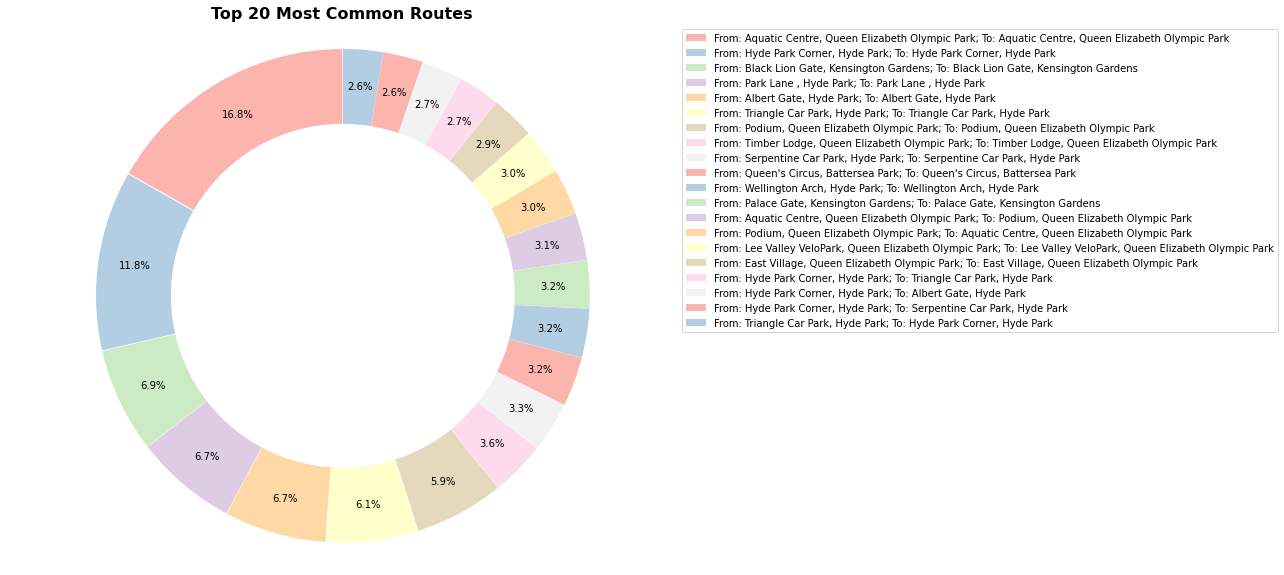

In [85]:
# Distribution of App Categories
most_common_routes_all_aux = most_common_routes_all_aux.head(20)
plotCats(df=most_common_routes_all_aux, col='station_comb', hue='comb', title='Top 20 Most Common Routes')

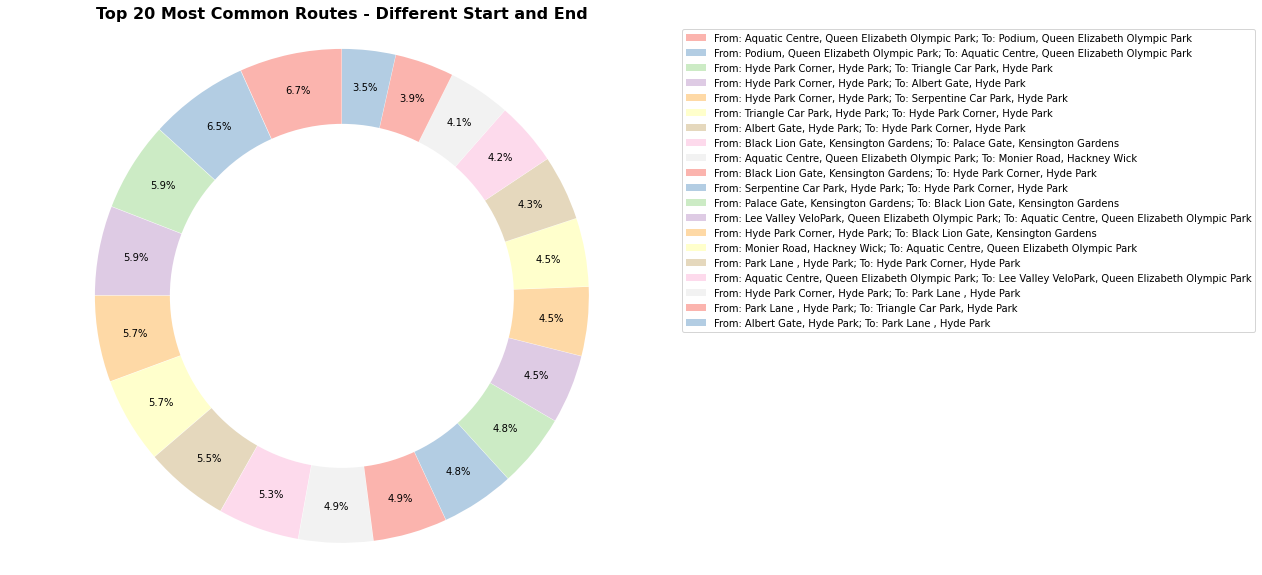

In [86]:
# Distribution of App Categories
most_common_routes_diff_aux = most_common_routes_diff_aux.head(20)
plotCats(df=most_common_routes_diff_aux, col='station_comb', hue='comb', title='Top 20 Most Common Routes - Different Start and End')

### 3.2 Most Used Bikes

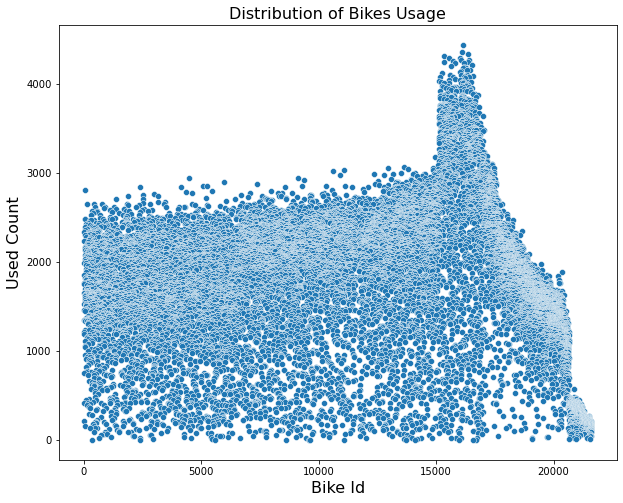

,Bike Id,Used_Count
0,16151,4436
1,16082,4354
2,16358,4337
3,15331,4313
4,16011,4286
5,15529,4285
6,16045,4267
7,16379,4262
8,15698,4254
9,16344,4246


In [51]:
most_used_bikes = cropped_cols['Bike Id'].value_counts().reset_index()
most_used_bikes.rename({'index':'Bike Id', 'Bike Id':'Used_Count'}, axis=1, inplace=True)

fig, ax = plt.subplots(figsize=(10, 8))
sns.scatterplot(data=most_used_bikes, x="Bike Id", y="Used_Count")
plt.title('Distribution of Bikes Usage', fontsize=16)
plt.xlabel('Bike Id', fontsize=16)
plt.ylabel('Used Count', fontsize=16)
plt.show()

most_used_bikes.head(10)

### 3.3 Workday and Weekends

In [52]:
#date_time_weather.set_index('time_stamp', inplace=True)
date_time_weather.describe()

,workday,covid_days,month,hour,peak_travel,trip_count,avg_temp,precipMM,WindGustKmph,cloudcover
count,52416.000000,52416.000000,52416.000000,52416.000000,52416.000000,52416.000000,52416.000000,52416.000000,52416.000000,52416.000000
mean,0.694139,0.218903,6.511905,11.750000,0.202457,593.554201,13.946658,2.511264,18.805861,54.522894
std,0.460775,0.413506,3.439308,6.926766,0.401835,568.677689,6.059711,5.172271,9.003384,26.792846
min,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,-2.250000,0.000000,3.000000,0.000000
25%,0.000000,0.000000,4.000000,5.875000,0.000000,115.000000,9.250000,0.000000,12.000000,35.000000
50%,1.000000,0.000000,7.000000,11.750000,0.000000,460.000000,13.250000,0.300000,17.000000,58.000000
75%,1.000000,0.000000,9.250000,17.625000,0.000000,869.000000,18.750000,2.425000,24.000000,76.000000
max,1.000000,1.000000,12.000000,23.500000,1.000000,3364.000000,33.000000,59.000000,60.000000,100.000000


In [89]:
def plot_boxplot(df, xcol, ycol, hue, title, xlabel, ylabel, leg=[]):
    """
    Creates a donut plot for a given Dataframe.
    
    Parameters
    ----------
    df : Pandas DataFrame
        The Dataframe of interest.
    xcol : string
        Column of interest in Dataframe df x-axis.
    ycol : string
        Column of interest in Dataframe df y-axis.
    title : string
        Title for the plot.
    xlabel : string
        Label x-axis.
    ylabel : string
        Label y-axis.
    leg : list
        List of labels for the legend.
    hue : str
        Criteria to group a certain variable.
    """
    if len(leg) == 2 or leg == []:
        # colour palettes for consistent displays
        palette = ['#DB4E18', '#F3BE26']
    elif len(leg) == 3:
        palette = ['#DB4E18', '#F3BE26', '#E669A2']

    # plot the distribution 
    fig, ax = plt.subplots(figsize=(20,6))

    ax = sns.boxplot(x=xcol, y=ycol, data=df, hue=hue, showfliers=False, palette = palette)
    
    
    hndl, lgnd = ax.get_legend_handles_labels()
    if leg != []:
        ax.legend(hndl, leg)
    else:
        ax.legend()
    ax.set_xticklabels(['0:00', '', '1:00', '', '2:00', '', '3:00', '', '4:00', '', '5:00', '', '6:00', '', '7:00', '', '8:00', '', '9:00', '', '10:00', '', '11:00', '', '12:00', \
                            '', '13:00', '', '14:00', '', '15:00', '', '16:00', '', '17:00', '', '18:00',  '', '19:00', '', '20:00', '', '21:00', '', '22:00', '', '23:00', ''])
    
    plt.title(title, fontweight="bold", fontsize=16)
    plt.xlabel(xlabel, fontsize=16)
    plt.ylabel(ylabel, fontsize=16)

    plt.show()

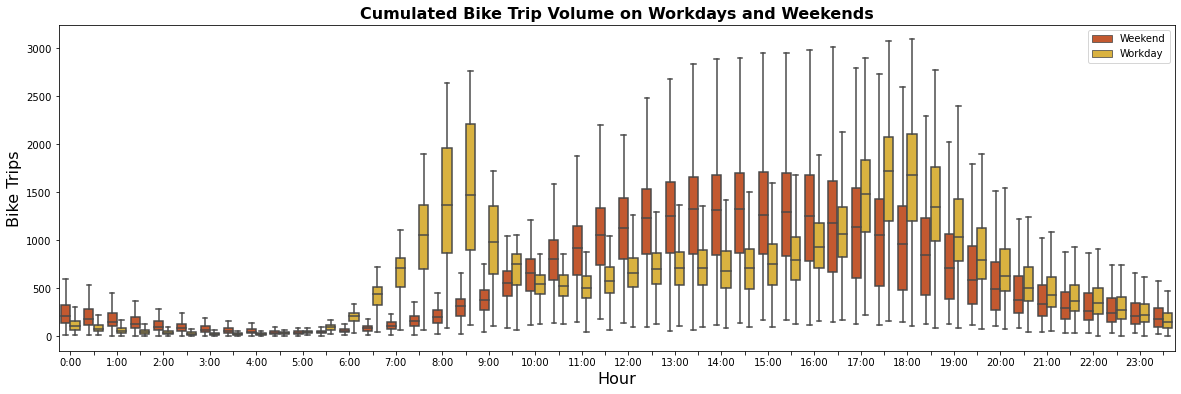

In [90]:
plot_boxplot(df=date_time_weather, xcol='hour', ycol='trip_count',
             hue='workday',
             title='Cumulated Bike Trip Volume on Workdays and Weekends',
             xlabel='Hour',
             ylabel='Bike Trips',
             leg = ['Weekend', 'Workday'])

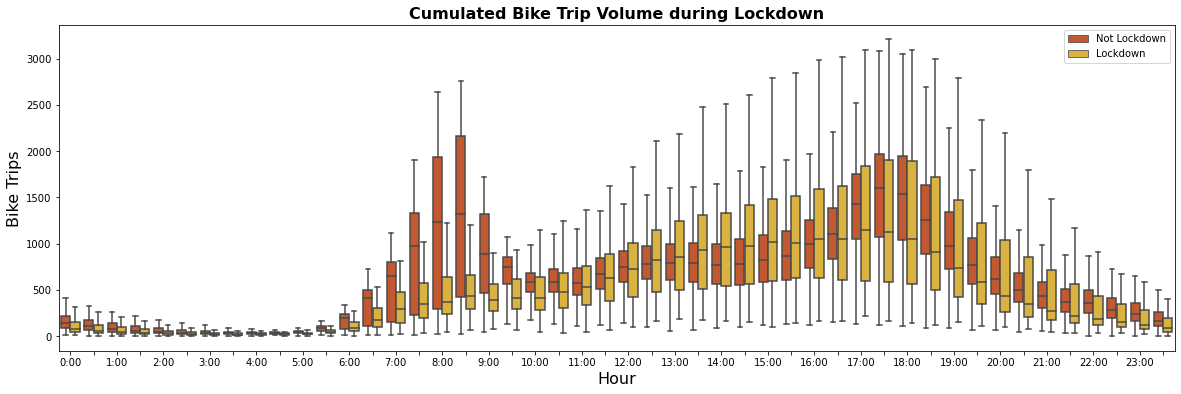

In [91]:
plot_boxplot(df=date_time_weather, xcol='hour', ycol='trip_count',
             hue='covid_days',
             title='Cumulated Bike Trip Volume during Lockdown',
             xlabel='Hour',
             ylabel='Bike Trips',
             leg = ['Not Lockdown','Lockdown'])

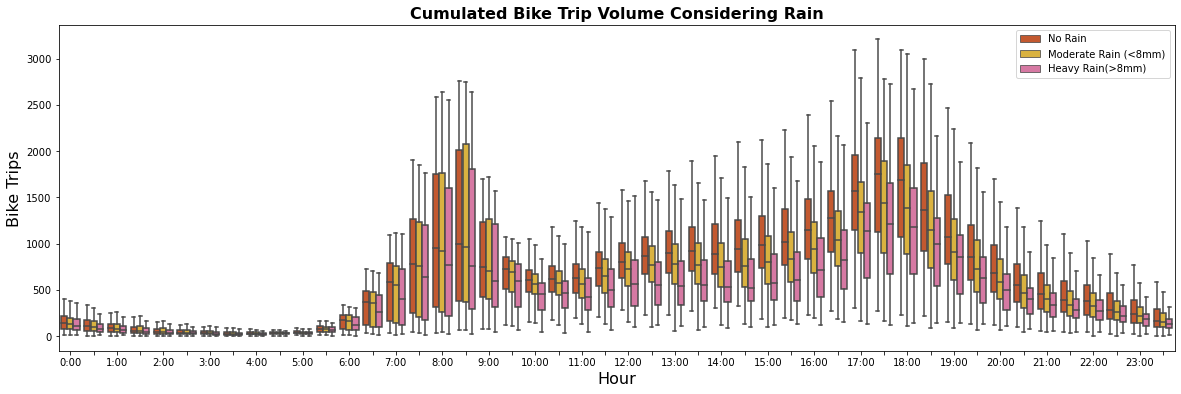

In [112]:
plot_boxplot(df=date_time_weather, xcol='hour', ycol='trip_count',
             hue='precipType',
             title='Cumulated Bike Trip Volume Considering Rain',
             xlabel='Hour',
             ylabel='Bike Trips',
             leg = ['No Rain','Moderate Rain (<8mm)','Heavy Rain(>8mm)'])

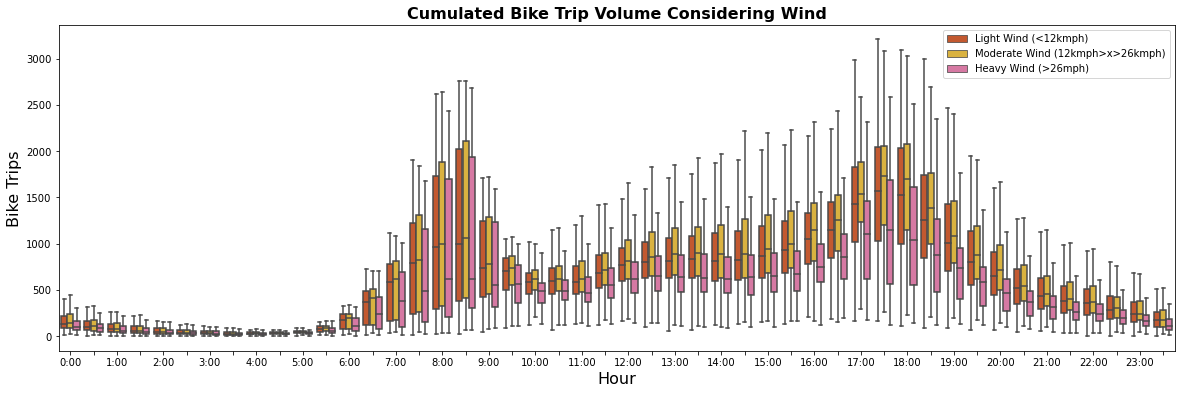

In [111]:
plot_boxplot(df=date_time_weather, xcol='hour', ycol='trip_count',
             hue='windType',
             title='Cumulated Bike Trip Volume Considering Wind',
             xlabel='Hour',
             ylabel='Bike Trips',
             leg = ['Light Wind (<12kmph)','Moderate Wind (12kmph>x>26kmph)','Heavy Wind (>26mph)'])

### 3.4 Data Correlation

In order to measure the relationship between different features, the Pearson correlation coefficient $\rho$ is calculated. This coefficient measures the linear relationship between two datasets. This coefficeint varies between [-1, 1] with 0 being no correlation and -1 and +1 implying linear relationship.

$$\rho = \frac{\sum \left(x-m_x\right)\left(y-m_y\right)}{\sqrt{\sum \left(x-m_x\right)^2 \left(y-m_y\right)^2}}$$

In [62]:
def corrfunc(x, y, ax=None, **kws):
    """
    Plot the correlation coefficient in the top left hand corner of a plot.
    
    Parameters
    ----------
    x : array_like
        Input array.
    y : array_like
        Input array.
        
    Reference: https://stackoverflow.com/questions/30942577/seaborn-correlation-coefficient-on-pairgrid
    """
    # Obtain Pearson coefficients
    r, _ = pearsonr(x, y)
    ax = ax or plt.gca()
    ax.annotate(f'ρ = {r:.2f}', xy=(.2, .95), xycoords=ax.transAxes)

def pairplot_disp(df):
    """
    Create a Pairplot for the provided Dataframe.
    
    Parameters
    ----------
    df : Pandas DataFrame
        The Dataframe of interest.
    color : string
        Chosen colour palette.
    """
    f = sns.pairplot(df,diag_kind='kde',palette=['#DB4E18'])
    f.map_lower(corrfunc)
    plt.show()

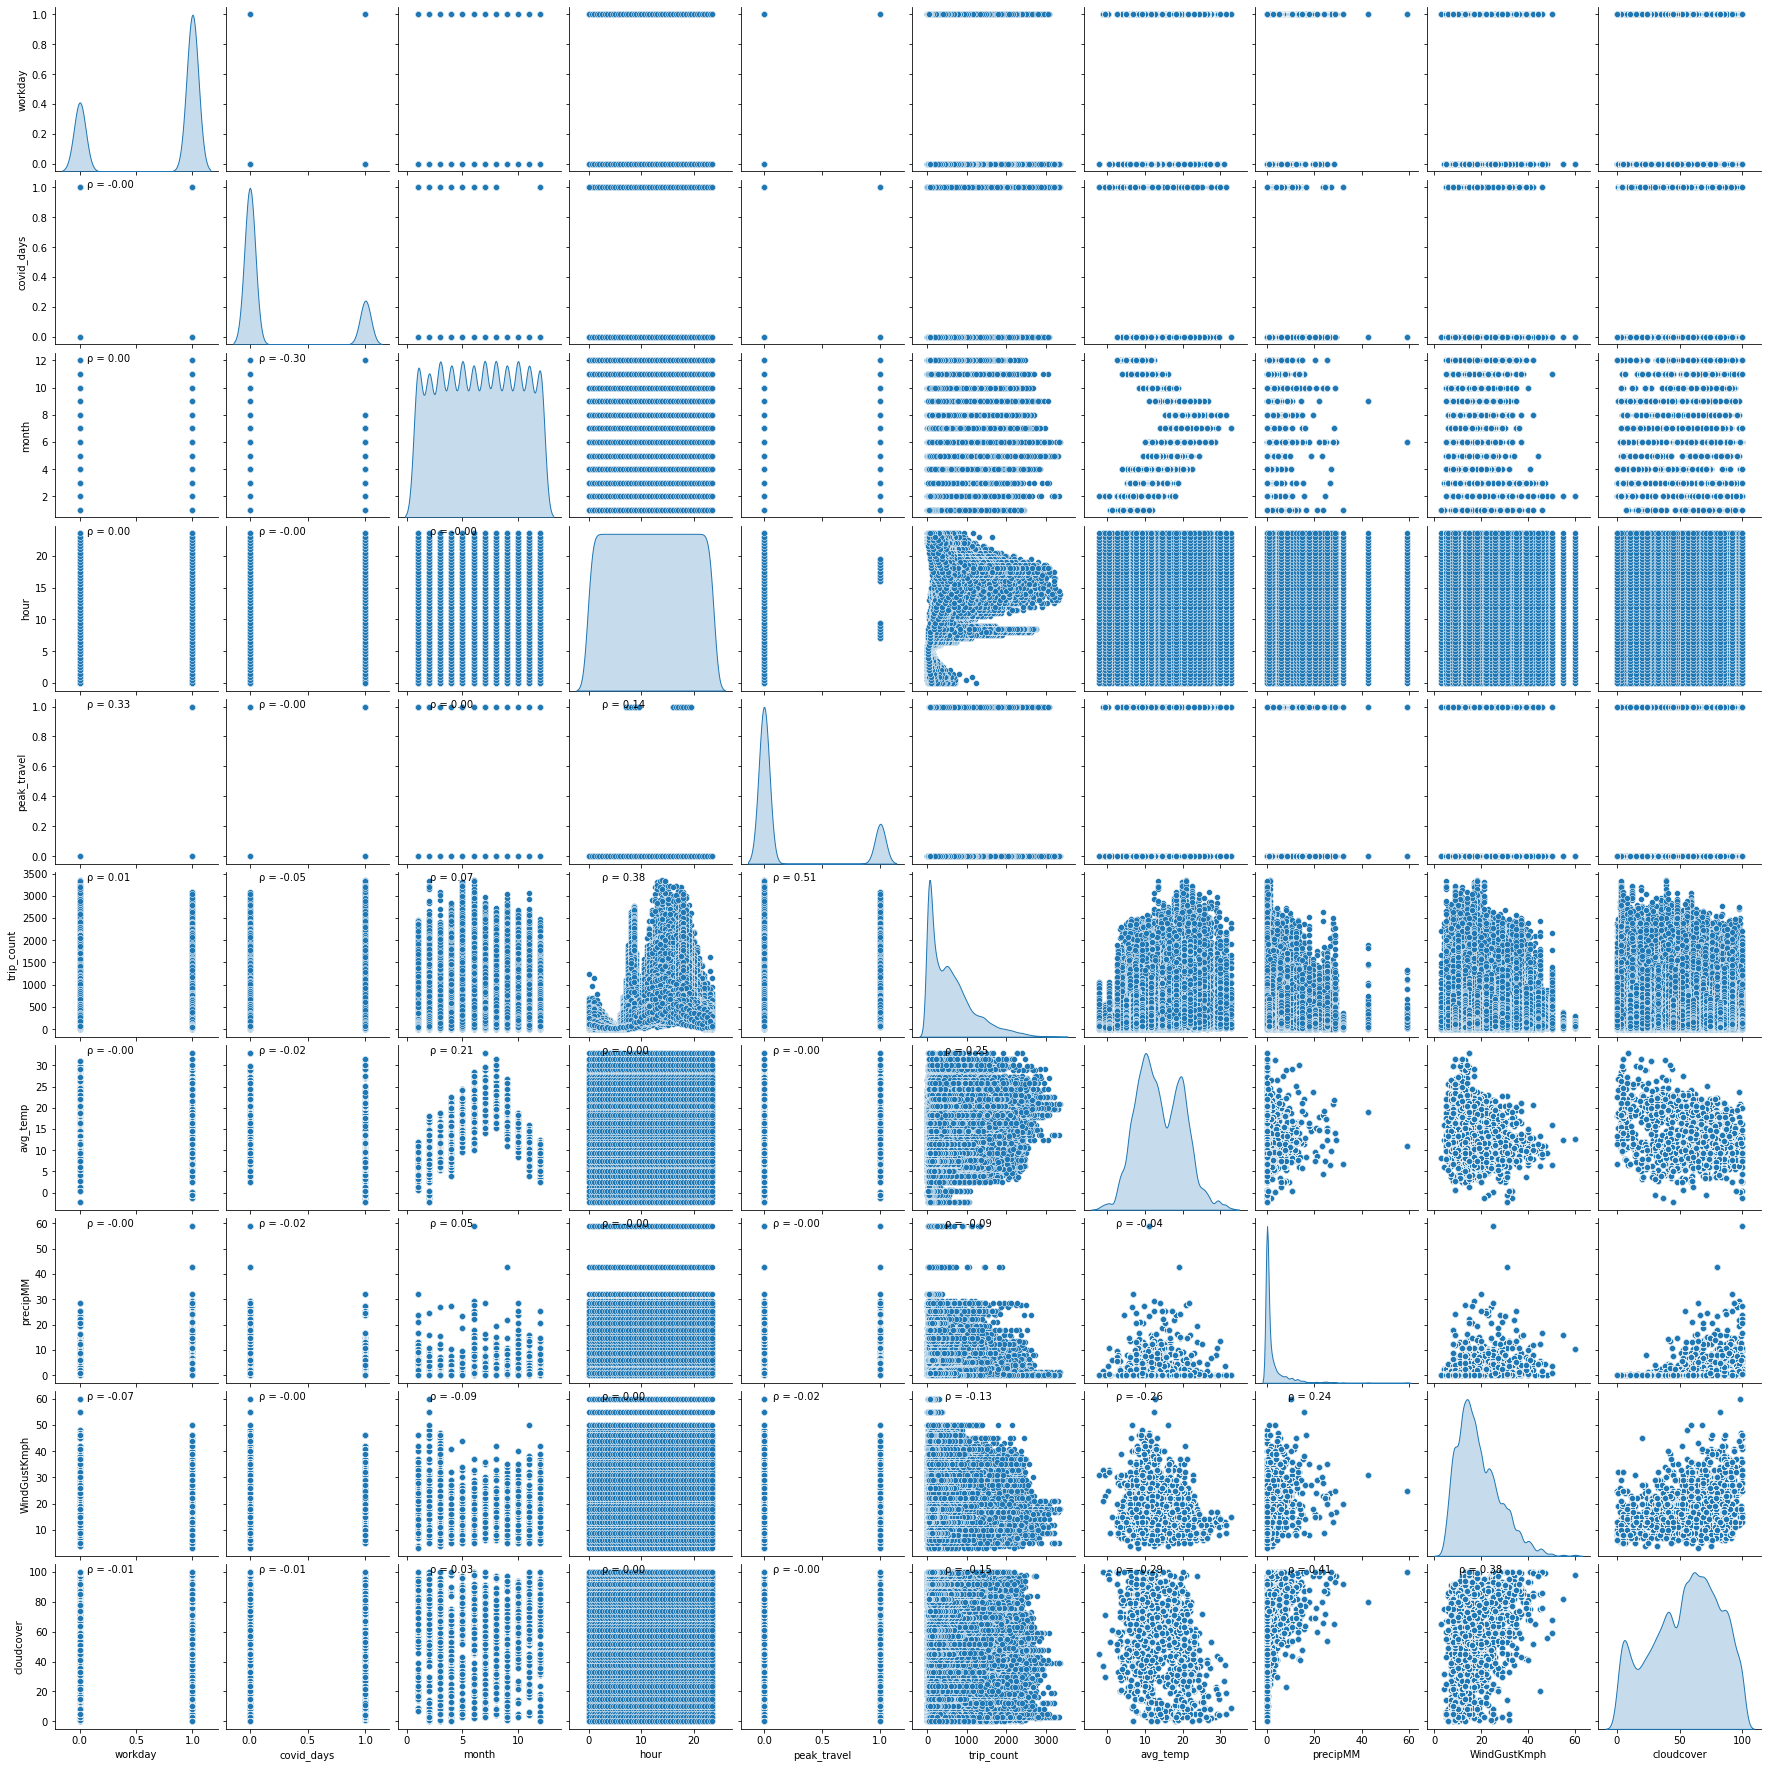

In [63]:
# Plot pairplot for the Dataframe
pairplot_disp(date_time_weather)

From the visualisation of data and pearson coefficients, the following conclusions can be reached:
- There is a strong relationship between the hour of the trip and the number of trips.
- There is a very strong relationship between peak hours and number of trips.
- There is a relationship between average temperature and number of trips.
- There is an inverse relationship between wind and number of trips.
- There is a strong relationship between wind and cloudcover and rain.
- As expected, there is a relationship between months and average temperature.


## 4 Use Cases

From the previous Exploratory Data Analysis the following Use Cases were identified:
- Predictive Bike Maintenance. Using historic data for every Bike ID to identify gaps where they were not used for maintenance purposes. Analyse life cycles of each Bike ID.
- Route Prediction for Jouneys using OSRM. To explore the most common routes with the Open Source Routing Machine. Perform an analysis of the traffic depending on the hours.
- Study of Impact of Tube Strikes. To analyse how Tube Strikes affected the rental of bikes. Analyse which stations were the busiest and the implications to nearby stations that this had around the busiest stations.
- Study of Impact of Covid-19. Study how the pandemic affected the use and distribution of trips.
- Prediction of Usage Trip Volume. Creating a model to estimate the number of rentals at a given time providing a set of input conditions. Results could be presented with key features that drive the number of bikes being rented.
- Creation of a Dashboard. Use Apache Airflow to gather data from the different sources, create a Data Warehouse (Amazon EMR or Azure Blob). Use parquet to connect data with a Dashboard that would automatically be updated as Airflow detected new data in the original sources.

## 5 Modelling - Prediction of Usage Trip Volume

In [64]:
date_time_weather.head()

,time_stamp,weekday_name,workday,covid_days,month,hour,peak_travel,just_date,trip_count,avg_temp,precipMM,WindGustKmph,cloudcover,precipType,windType
0,2019-01-02 00:00:00,Wednesday,1,0,1,0.0,0,2019-01-02,48,5.5,0.0,13,23,No Rain,Moderate Wind
1,2019-01-02 00:30:00,Wednesday,1,0,1,0.5,0,2019-01-02,45,5.5,0.0,13,23,No Rain,Moderate Wind
2,2019-01-02 01:00:00,Wednesday,1,0,1,1.0,0,2019-01-02,42,5.5,0.0,13,23,No Rain,Moderate Wind
3,2019-01-02 01:30:00,Wednesday,1,0,1,1.5,0,2019-01-02,22,5.5,0.0,13,23,No Rain,Moderate Wind
4,2019-01-02 02:00:00,Wednesday,1,0,1,2.0,0,2019-01-02,10,5.5,0.0,13,23,No Rain,Moderate Wind


In [114]:
def create_dfResults(X_test, y_test, y_pred):
    '''
    Obtain a Dataframe with test and predicted data.
    
    Parameters
    -------
    X_test : Pandas DataFrame
        Test DataFrame.
    y_test : Pandas Series
        Series with feature data.
    y_pred : Pandas Series
        Series with predicted feature data.
    Returns
    -------
    df : Pandas DataFrame
        Concatenated Dataframe with predicted and test data.
    '''
    df = pd.DataFrame({'trips':y_test,
                       'hour':X_test['hour'],
                       'type': 'Actual'})
    df_aux = pd.DataFrame({'trips':y_pred,
                           'hour':X_test['hour'],
                           'type':'Predicted'})
    
    return  pd.concat([df,df_aux])

### 5.1 Train-Test Split

Firstly, non-relevant columns need to be dropped. This is done not to affect the performance of the model in both accuracy and 
training time.
- _time_stamp_ 
- _just_date_ 
- _precipType_ 
- _windType_
- _trip_count_

To split the data into train and test subsets, the _train_test_split()_ method is used, using a test size of 30% of the dataset.

In [69]:
# Dropping columns that are not relevant for our analysis
X = date_time_weather.drop(['time_stamp','just_date','precipType','windType', 'trip_count'],axis=1)

# Selecting target variable
y = date_time_weather['trip_count']

# Splitting data in train and test subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) #splitting data into train/test sets

X_train.head()

,weekday_name,workday,covid_days,month,hour,peak_travel,avg_temp,precipMM,WindGustKmph,cloudcover
40455,Friday,1,0,4,19.5,1,13.25,0.0,13,0
7685,Tuesday,1,0,6,2.5,0,16.75,13.0,11,90
46263,Sunday,0,0,8,19.5,0,17.75,2.8,15,86
36567,Monday,1,1,2,19.5,1,5.50,0.4,11,94
51244,Saturday,0,0,12,14.0,0,6.25,0.3,24,48


### 5.2 Column Transformer

In order to pre-process the numerical and categorical data in the dataset, two column transformations will be performed as part of the Pipeline. `StandardScaler` is applied to numerical data standardising features removing the mean and scaling to unit variance. For categorical data, `OneHotEncoder` is used to encode features a one-hot numeric array creating binary columns for each category.

In [70]:
preprocessor = make_column_transformer(
    (StandardScaler(), ["workday", "covid_days", "month", "hour", "peak_travel", "avg_temp", "precipMM", "WindGustKmph","cloudcover"]),
    (OneHotEncoder(handle_unknown="ignore"), ["weekday_name"]))

### 5.3 Regression Models Deployment

In order to select which model is best to predict the behaviour of our data, different alternatives will be fitted and tested.
- Linear Regression.
- SVC.
- Random Forest Regressor.

#### 5.3.1 Linear Regression

In [101]:
# Initialising the Logistic Regression classifier
linReg = LinearRegression()

# Construct a Pipeline from the given estimators
pipe = make_pipeline(preprocessor, linReg)

# Fit the model to the training data
pipe.fit(X_train, y_train)

# Transform data and perform an estimation
y_pred = pipe.predict(X_test)

print('Accuracy of Logistic Regression: {:.6f}'.format(pipe.score(X_test,y_test)))
print ('Mean Squared Error: {:.6f}'.format(mean_squared_error(y_test,y_pred)))
print ('Mean absolute Error: {:.6f}'.format(mean_absolute_error(y_test,y_pred)))

Accuracy of Logistic Regression: 0.455238
Mean Squared Error: 174439.933169
Mean absolute Error: 316.436254


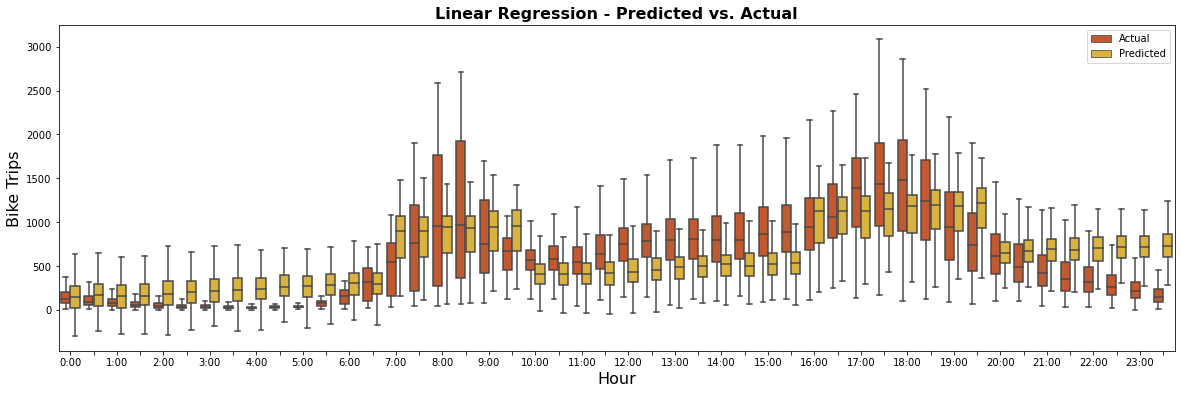

In [102]:
resultsLR = create_dfResults(X_test, y_test, y_pred)
plot_boxplot(df=resultsLR, xcol='hour', ycol='trips',
             hue='type',
             title='Linear Regression - Predicted vs. Actual',
             xlabel='Hour',
             ylabel='Bike Trips')

#### 5.3.2 Support Vector Regression

In [98]:
# Initialising the Support Vector Regressor
svc_reg = SVR()

# Construct a Pipeline from the given estimators
pipe_SVR = make_pipeline(preprocessor, svc_reg)

# Fit the model to the training data
pipe_SVR.fit(X_train, y_train)

# Transform data and perform an estimation
y_pred = pipe_SVR.predict(X_test)

print('Accuracy of SVC: {:.6f}'.format(pipe_SVR.score(X_test, y_test)))
print ('Mean Squared Error: {:.6f}'.format(mean_squared_error(y_test,y_pred)))
print ('Mean absolute Error: {:.6f}'.format(mean_absolute_error(y_test,y_pred)))

Accuracy of SVC: 0.460910
Mean Squared Error: 172623.759122
Mean absolute Error: 273.831308


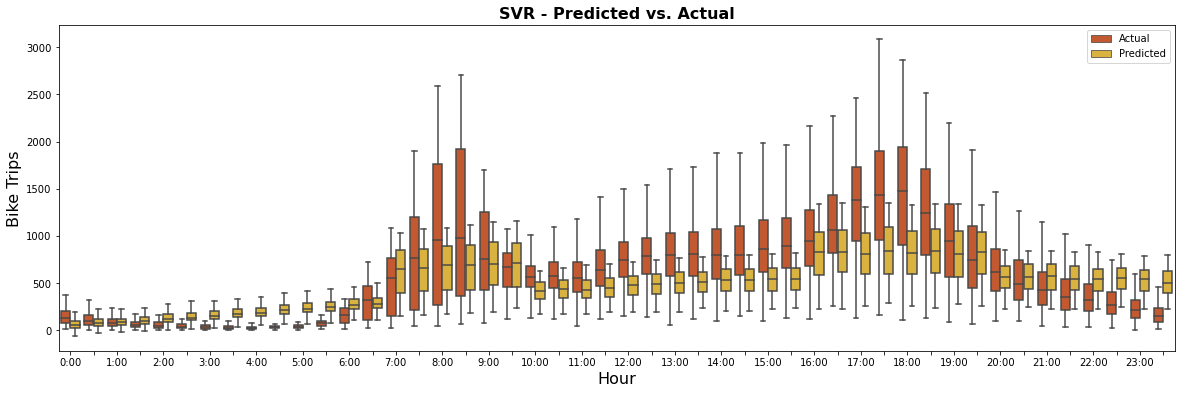

In [99]:
resultsSVR = create_dfResults(X_test, y_test, y_pred)
plot_boxplot(df=resultsSVR, xcol='hour', ycol='trips',
             hue='type',
             title='SVR - Predicted vs. Actual',
             xlabel='Hour',
             ylabel='Bike Trips')

#### 5.3.3 Random Forest Regressor

Best Estimator N: 290
Best Accuracy Score: 0.946169


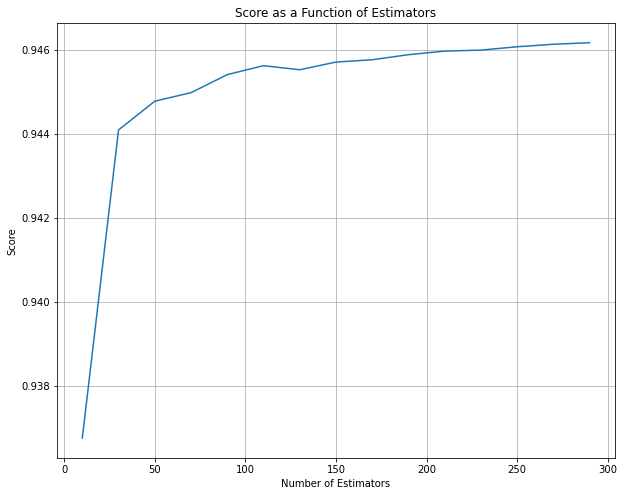

In [74]:
# Range of estimators to explore
estimators = np.arange(10, 300, 20)
#estimators = [20]

scores = [] # Intialise list to store the scores of different estimators
top_estimator = 0 # Initialisation of best estimator
top_score = 0 # Initialisation of best score

for n in estimators:
    # Initialising Random Forest Classifier
    forest = RandomForestRegressor(n_estimators=n, random_state=42)
    
    # Construct a Pipeline from the given estimators
    pipe_RFR = make_pipeline(preprocessor, forest)
    
    # Fit the model to the training data
    pipe_RFR.fit(X_train, y_train)
    
    # Assess the score of the pipeline
    score = pipe_RFR.score(X_test, y_test)
    
    top_estimator = n if top_score < score else top_estimator
    top_score = score if top_score < score else top_score
    scores.append(score)
    
ax, fig = plt.subplots(figsize=(10, 8))
plt.title("Score as a Function of Estimators")
plt.xlabel("Number of Estimators")
plt.ylabel("Score")
plt.grid()
plt.plot(estimators, scores)

print("Best Estimator N: {}".format(top_estimator))
print("Best Accuracy Score: {:.6f}".format(top_score))

In [103]:
# Initialise Random Forest Classifier using the optimal number of estimators
best_forest = RandomForestRegressor(n_estimators=top_estimator, random_state=42)

# Construct a Pipeline from the given estimators
best_pipe = make_pipeline(preprocessor, best_forest)

# Fit the model to the training data
best_pipe.fit(X_train, y_train)

y_pred = best_pipe.predict(X_test)

print('Accuracy of RFR: {:.6f}'.format(best_pipe.score(X_test, y_test)))
print('Best Model/Pipeline MAE: {:.6f}'.format(mean_absolute_error(y_test,y_pred)))
print('Mean Squared Error: {:.6f}'.format(mean_squared_error(y_test,y_pred)))

Accuracy of RFR: 0.946169
Best Model/Pipeline MAE: 73.931833
Mean Squared Error: 17237.416670
Mean absolute Error: 73.931833


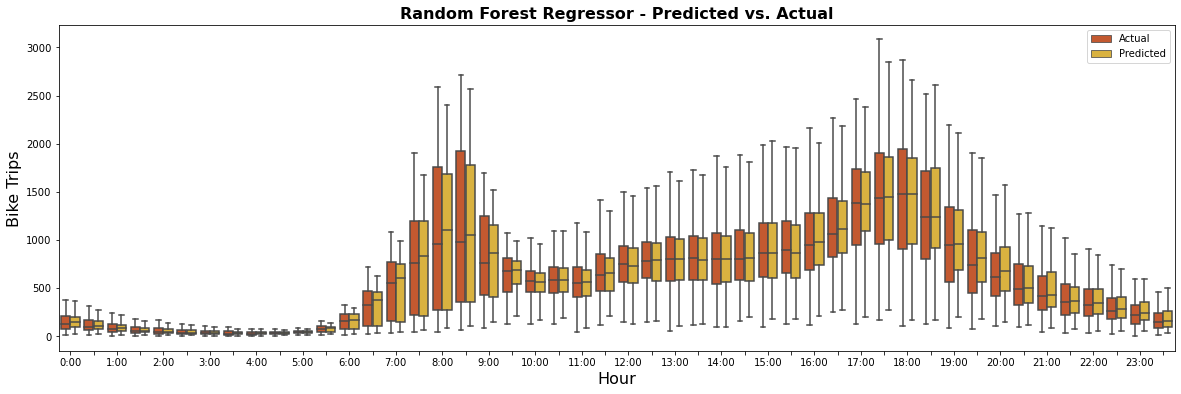

In [97]:
resultsRFR = create_dfResults(X_test, y_test, y_pred)
plot_boxplot(df=resultsRFR, xcol='hour', ycol='trips',
             hue='type',
             title='Random Forest Regressor - Predicted vs. Actual',
             xlabel='Hour',
             ylabel='Bike Trips')

### 5.4 Feature Importance Analysis

In order to understand how different features affect the decision-making process, Feature Importance is used to calculate a score for how relevant the input features are to predict the outcome of a given model or pipeline.

The scores represents the importance of each feature, a higher score means that the specific feature will have a larger effect on the model that is being used to predict a certain value on a regression task.

From the figure below, it can be concluded that the main features are:
- Hour - 55.60%
- Average Temperature - 11.50%
- Peak Travel Hour - 10.85%
- Workday - 4.55%
- Covid Lockdown - 3.99%

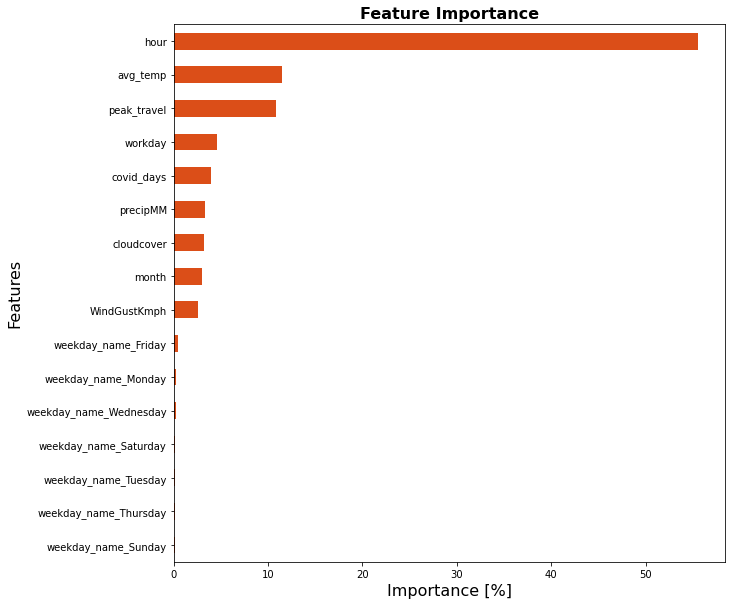

In [104]:
fig, ax = plt.subplots(figsize=(10, 8))

oh_labels = pipe.named_steps['columntransformer'].named_transformers_['onehotencoder'].get_feature_names_out(input_features=["weekday_name"])
feature_names = list(X.drop(['weekday_name'],axis=1).columns)+list(oh_labels)

# Create Series of feature importances
importances_best = pd.Series(best_pipe.steps[1][1].feature_importances_,index=feature_names)

# Sort Importances
sorted_importances = importances_best.sort_values()*100

# Plot Feature Importances
sorted_importances.plot(kind='barh',figsize=(10,8),color = ['#DB4E18'])

fig.tight_layout()
plt.title('Feature Importance', fontweight="bold", fontsize=16)
plt.xlabel('Importance [%]', fontsize=16)
plt.ylabel('Features', fontsize=16)
plt.show()

In [78]:
sorted_importances.tail(5)

covid_days      3.993708
workday         4.551684
peak_travel    10.854970
avg_temp       11.497718
hour           55.604285
dtype: float64

## 6 Conclusions and Future Work

The data collected from the rental bikes in London between 2019 and 2021 concludes that there is a high demand for rental bikes in London. The number of rental bikes has increased as it is an option that Londoners consider at weekends. It is a popular alternative to public transportation for daily commutes. Rainy or windy days have been shown to have a direct negative impact in the number of rentals. The top 20 most common routes all have as origin or destination a park or garden in London. During the Covid-19 lockdowns, bikes were mostly used after 16:00, after work as a means of leisure.

As future work, there are a few options that should be explroed: the effect of tourism, route prediction for journeys using OSRM or the creation of an interactive dashboard using Apache Airflow, a Data Warehouse and a Dashboard such as the ones provided by Metabase.